<a href="https://colab.research.google.com/github/SatK-ds2020/CNN-projects/blob/main/Lung_Cancer_Detection_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [3]:
from zipfile import ZipFile
file_name = "/content/lung_image_sets.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [24]:
from zipfile import ZipFile
file_name = "/content/colon_image_sets.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [4]:
path = '/content/lung-cancer'
classes = os.listdir(path)
classes

['lung_n', 'lung_scc', 'lung_aca']

In [3]:
path = '/content/colon-cancer'
classes = os.listdir(path)
classes

['colon_n', 'colon_aca']

In [2]:
lung_path = '/content/lung-cancer'
colon_path = '/content/colon-cancer'

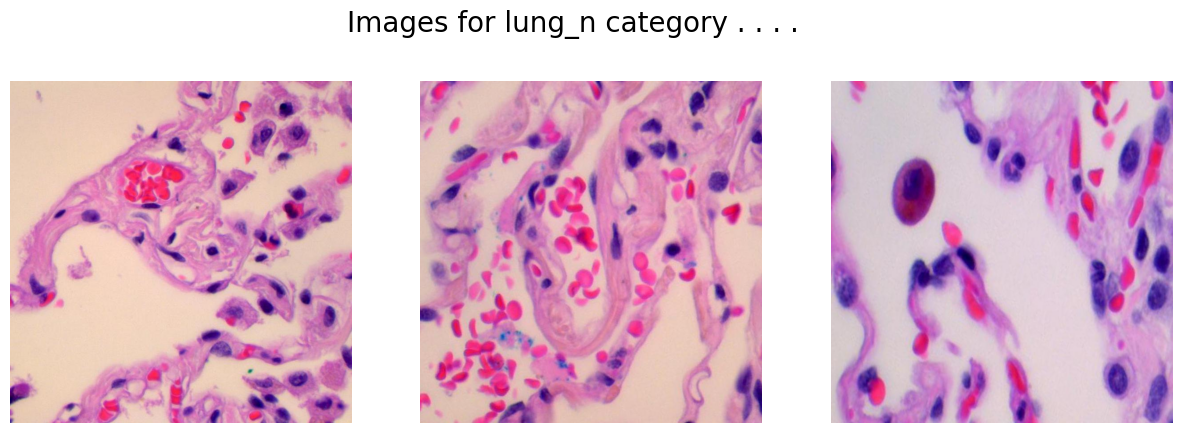

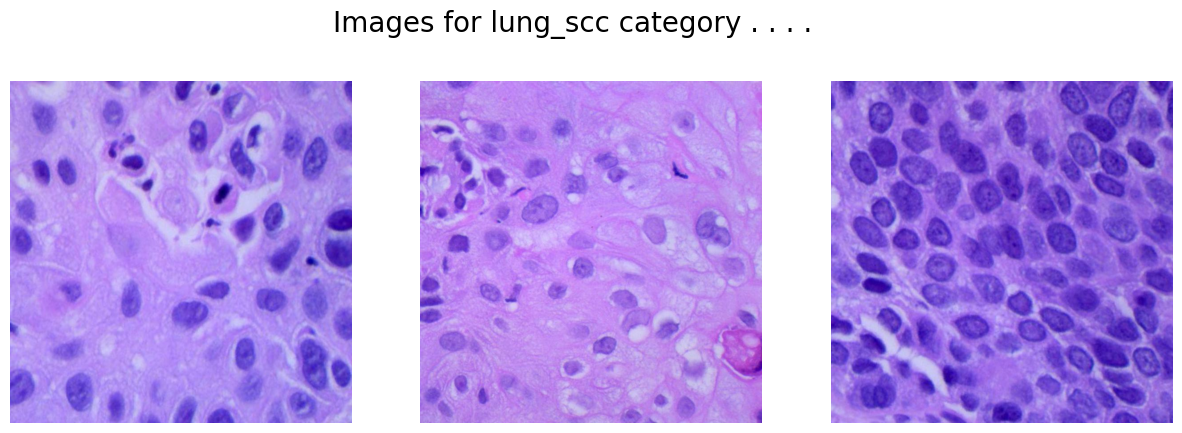

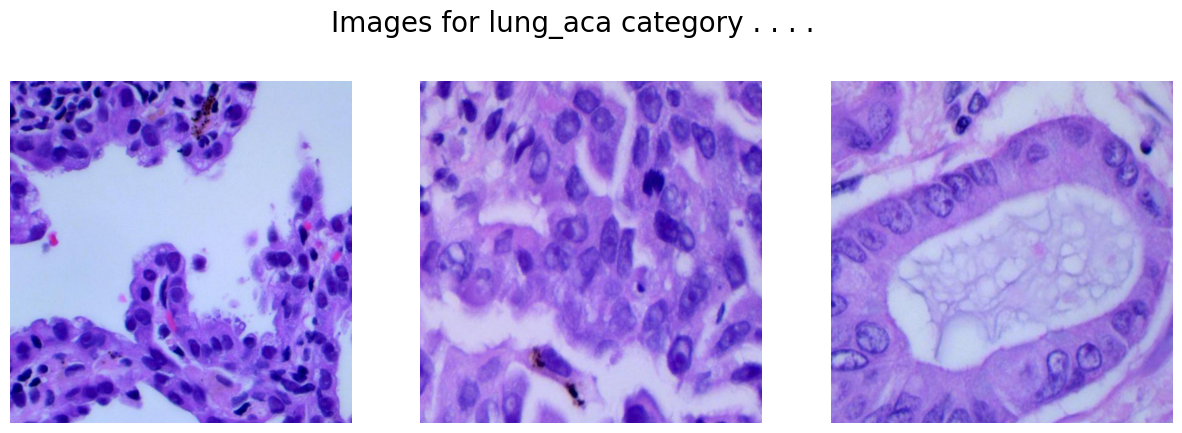

In [5]:
lung_path = '/content/lung-cancer'

for cat in classes:
    image_dir = f'{Lung_path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{lung_path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

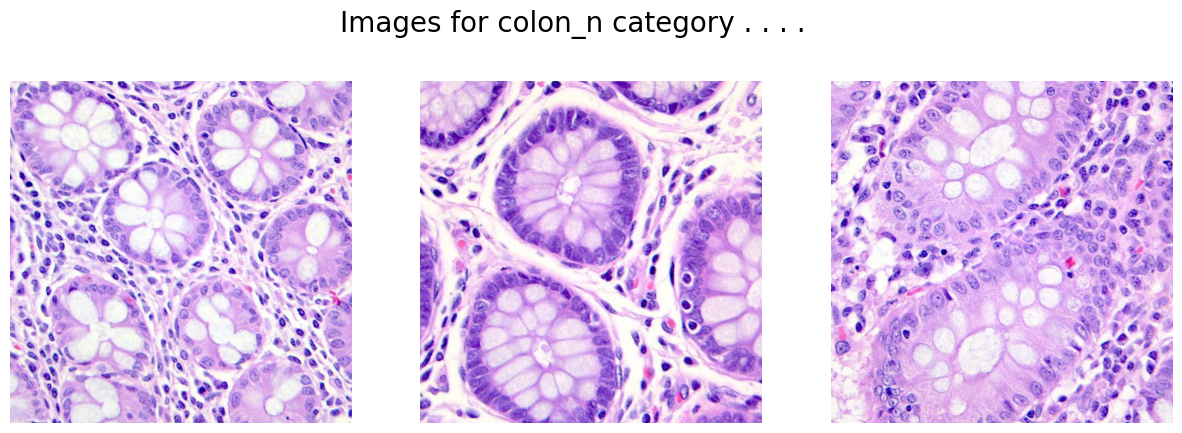

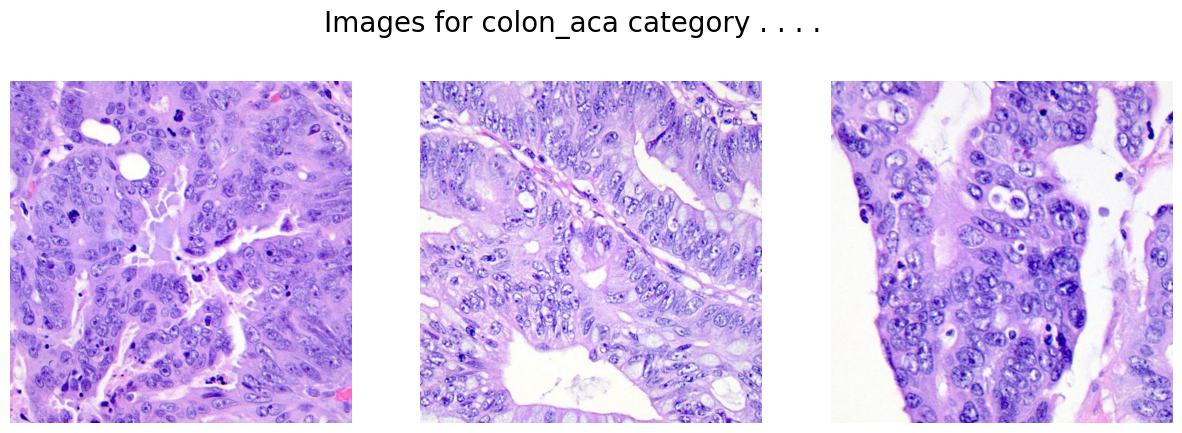

In [4]:
colon_path = '/content/colon-cancer'

for cat in classes:
    image_dir = f'{colon_path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [7]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{colon_path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [10]:
    import shutil
    import os

    folder_path = "/content/lung_scc"

    if os.path.exists(folder_path):
      shutil.rmtree(folder_path)
      print(f"Folder '{folder_path}' and its contents removed successfully.")
    else:
      print(f"Folder '{folder_path}' not found.")

Folder '/content/lung_scc' and its contents removed successfully.


In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [7]:
# test-train split for colon samples
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(8000, 256, 256, 3) (2000, 256, 256, 3)


In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)

In [9]:
len(pre_trained_model.layers)

311

In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [11]:
last_layer = pre_trained_model.get_layer('mixed7')
output_shape = last_layer.input[0].shape

print('last layer output shape: ', output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 192)


In [16]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
# output = layers.Dense(3, activation='softmax')(x) ----------------------output layer 3 for lung cancer of 3 classes
output = layers.Dense(2, activation='softmax')(x) #-------------------output layer 2 for colon cancer with 2 classes

model = keras.Model(pre_trained_model.input, output)

In [38]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [17]:
# model for colon-cancer
model.compile(
	optimizer='adam',
	loss='binary_crossentropy',
	metrics=['accuracy']
)

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

In [19]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 296ms/step - accuracy: 0.7942 - loss: 0.5106 - val_accuracy: 0.8130 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 178ms/step - accuracy: 0.9137 - loss: 0.2175 - val_accuracy: 0.7743 - val_loss: 0.6624 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9358 - loss: 0.1697
 Validation accuracy has reached upto 90%      so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 159ms/step - accuracy: 0.9358 - loss: 0.1697 - val_accuracy: 0.9110 - val_loss: 0.2386 - learning_rate: 0.0010


In [19]:
# colon cancer model fit
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 276ms/step - accuracy: 0.8253 - loss: 0.4152 - val_accuracy: 0.6650 - val_loss: 0.9202 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.9495 - loss: 0.1394 - val_accuracy: 0.8540 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.9635 - loss: 0.0964 - val_accuracy: 0.8140 - val_loss: 0.5965 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9779 - loss: 0.0632
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.9779 - loss: 0.0632 - val_accuracy: 0.7920 - val_loss: 0.7150 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9896 - loss: 0.0380
 Validation accuracy has reached upto 90%      so, stopping further training.
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.989

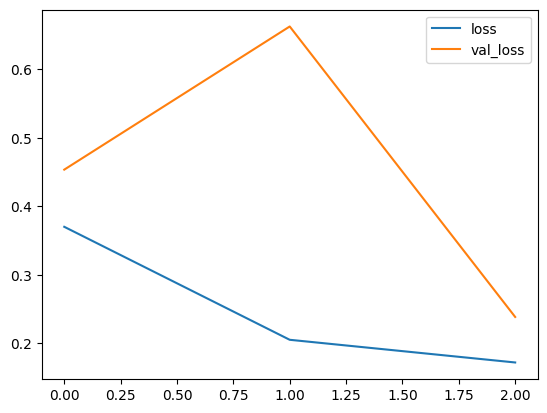

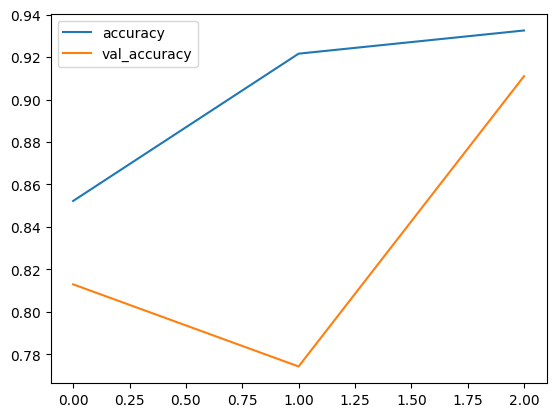

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

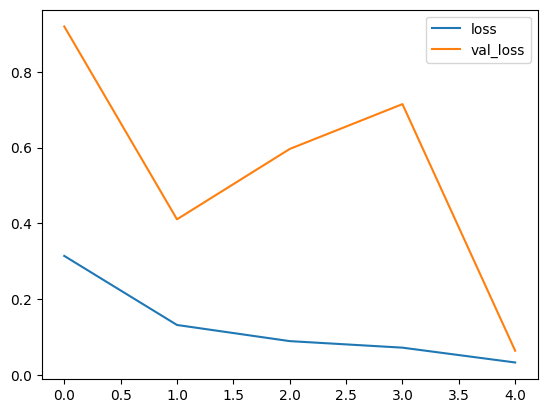

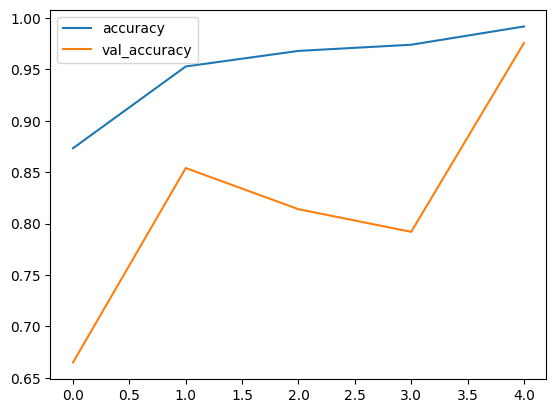

In [21]:
colon_history_df = pd.DataFrame(history.history)
colon_history_df.loc[:,['loss','val_loss']].plot()
colon_history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [21]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step


In [22]:
#colon cancer
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step


In [22]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 924,    0,   63],
       [   0,  797,  180],
       [   1,   23, 1012]])

In [23]:
#colon cancer
metrics.confusion_matrix(Y_val, Y_pred)

array([[964,  15],
       [ 34, 987]])

In [23]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

              precision    recall  f1-score   support

      lung_n       1.00      0.94      0.97       987
    lung_scc       0.97      0.82      0.89       977
    lung_aca       0.81      0.98      0.88      1036

    accuracy                           0.91      3000
   macro avg       0.93      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000



In [24]:
#colon cancer
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

              precision    recall  f1-score   support

     colon_n       0.97      0.98      0.98       979
   colon_aca       0.99      0.97      0.98      1021

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras import optimizers


IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

path=lung_path
classes = os.listdir(path)
classes

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

# train-test split

X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)


# Load pre-trained ResNet50 model
pre_trained_model = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

# Freeze pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Adding custom layers
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# custom call back function
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

# model training
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

# ploting val loss or acc
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# model prediction
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

# confusion matrix
metrics.confusion_matrix(Y_val, Y_pred)

print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


(12000, 256, 256, 3) (3000, 256, 256, 3)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9218 - loss: 0.1924
 Validation accuracy has reached upto 90%      so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 345ms/step - accuracy: 0.9220 - loss: 0.1920 - val_accuracy: 0.9913 - val_loss: 0.0274 - learning_rate: 0.0010
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       987
    lung_scc       0.99      0.98      0.99       977
    lung_aca       0.98      0.99      0.99      1036

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



(8000, 256, 256, 3) (2000, 256, 256, 3)
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9659 - loss: 0.0953
 Validation accuracy has reached upto 90%      so, stopping further training.
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 314ms/step - accuracy: 0.9661 - loss: 0.0948 - val_accuracy: 0.9885 - val_loss: 0.0327 - learning_rate: 0.0010


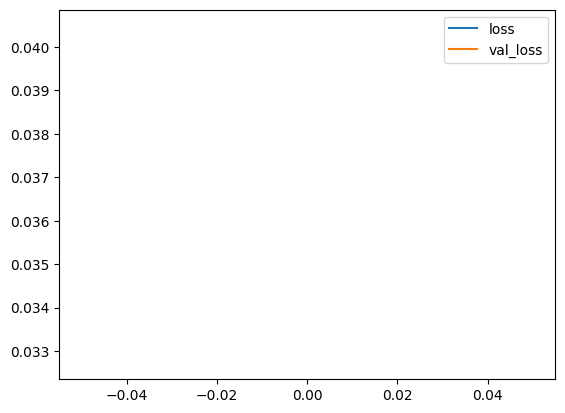

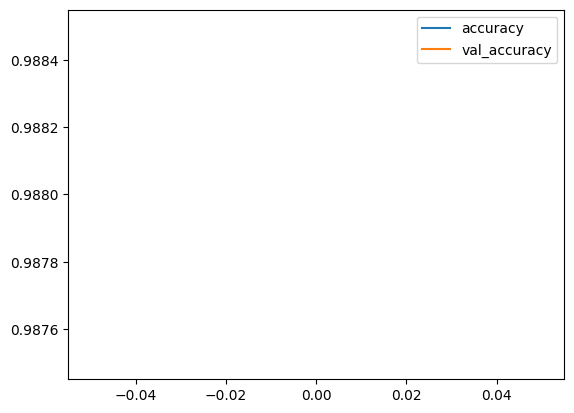

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step
              precision    recall  f1-score   support

     colon_n       0.98      1.00      0.99       979
   colon_aca       1.00      0.98      0.99      1021

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras import optimizers


IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

path=colon_path
classes = os.listdir(path)
classes

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

# train-test split

X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)


# Load pre-trained ResNet50 model
pre_trained_model = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

# Freeze pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Adding custom layers
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# custom call back function
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

# model training
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


# model prediction
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

# confusion matrix
metrics.confusion_matrix(Y_val, Y_pred)

print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

In [6]:
model.save('colon_cancer_model.h5')

(12000, 256, 256, 3) (3000, 256, 256, 3)
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9120 - loss: 0.2132
 Validation accuracy has reached upto 90%      so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 165s 733ms/step - accuracy: 0.9122 - loss: 0.2128 - val_accuracy: 0.9753 - val_loss: 0.0654 - learning_rate: 0.0010


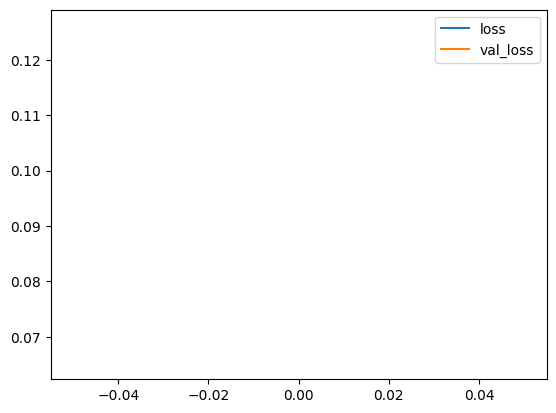

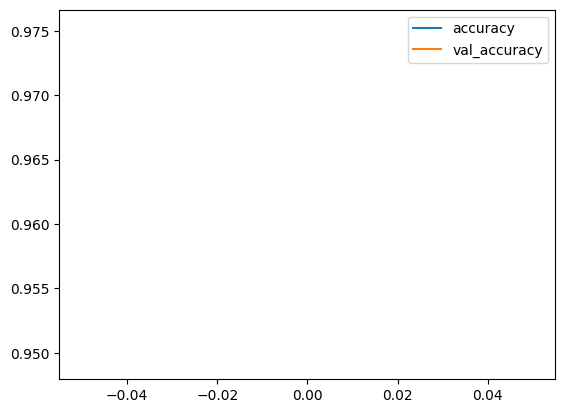

94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 337ms/step
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       987
    lung_scc       0.99      0.94      0.96       977
    lung_aca       0.94      0.99      0.97      1036

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
from tensorflow.keras import optimizers

IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

path=lung_path
classes = os.listdir(path)
classes

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

# train-test split

X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

# Load pre-trained VGG16 model
pre_trained_model = VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

# Freeze pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Adding custom layers
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# custom call back function
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

# model training
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

# plotting model loss or accuracy
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# model prediction
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

# confusion matrix
metrics.confusion_matrix(Y_val, Y_pred)

print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


In [4]:
model.save('lung_cancer_model.h5')